# Chest X Ray Pulmonary Diagnoses using DenseNet for Indian data
## 4A Semester project, Mahindra University
### Dipyaman Roy, Suchir R Punuru

---

## Imports

In [3]:
# Import necessary packages
import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import sklearn
import shap
import os
import seaborn as sns
import time
import pickle

sns.set()

# Removes unnecessary TF AVX instructions errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

# This sets a common size for all the figures to be drawn.
plt.rcParams['figure.figsize'] = [10, 7]

## Data Exploration
Getting familiarized with chest x-ray images taken from the public [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315). The following are using the images classified with methods outlined in [Holste et al. (2023)](https://arxiv.org/abs/2308.09180). 

In [4]:
# Read csv file containing training data
train_df = pd.read_csv("data/CXR8/PruneCXR/miccai2023_nih-cxr-lt_labels_train.csv")
valid_df = pd.read_csv("data/CXR8/PruneCXR/miccai2023_nih-cxr-lt_labels_val.csv")
test_df = pd.read_csv("data/CXR8/PruneCXR/miccai2023_nih-cxr-lt_labels_test.csv")
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in the train data frame')
train_df.head()

There are 78506 rows and 22 columns in the train data frame


,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subj_id
0,00000001_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,00000001_001.png,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,00000001_002.png,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,00000002_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
4,00000004_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [5]:
print(f"Train set: The total subject ids are {train_df['subj_id'].count()}, from those the unique ids are {train_df['subj_id'].value_counts().shape[0]} ")
print(f"Validation set: The total subject ids are {valid_df['subj_id'].count()}")
print(f"Test set: The total subject ids are {test_df['subj_id'].count()}")

Train set: The total subject ids are 78506, from those the unique ids are 24507 
Validation set: The total subject ids are 12533
Test set: The total subject ids are 21081


### Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

In [6]:
def check_for_leakage(df1, df2, subj_col):
    """
    Return True if there any subjects are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        subj_col (str): string name of column with subject IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    
    df1_subjects_unique = set(df1['subj_id'])
    df2_subjects_unique = set(df2['subj_id'])
    
    subjects_in_both_groups = list(df1_subjects_unique.intersection(df2_subjects_unique))

    # leakage contains true if there is subject overlap, otherwise false.
    leakage = len(subjects_in_both_groups) > 0 
        
    return leakage

In [7]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'subj_id')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'subj_id')))

leakage between train and test: False
leakage between valid and test: False


### Explore data labels
Create a list of the names of each patient condition or disease. 

In [8]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['id', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural Thickening', 'Pneumonia', 'Pneumothorax', 'Pneumoperitoneum', 'Pneumomediastinum', 'Subcutaneous Emphysema', 'Tortuous Aorta', 'Calcification of the Aorta', 'No Finding', 'subj_id']


In [9]:
# Remove unnecesary elements
columns.remove('id')
columns.remove('subj_id')

# Get the total classes
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")

# Print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

There are 20 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural Thickening', 'Pneumonia', 'Pneumothorax', 'Pneumoperitoneum', 'Pneumomediastinum', 'Subcutaneous Emphysema', 'Tortuous Aorta', 'Calcification of the Aorta', 'No Finding']
The class Atelectasis has 7587 samples
The class Cardiomegaly has 1590 samples
The class Consolidation has 2626 samples
The class Edema has 1283 samples
The class Effusion has 7919 samples
The class Emphysema has 1327 samples
The class Fibrosis has 1138 samples
The class Hernia has 130 samples
The class Infiltration has 12739 samples
The class Mass has 3689 samples
The class Nodule has 4359 samples
The class Pleural Thickening has 1998 samples
The class Pneumonia has 806 samples
The class Pneumothorax has 2432 samples
The class Pneumoperitoneum has 214 samples
The class Pneumomediastinum has 88 samples
The class Subcutan

### Data Visualization
Using the image names listed in the csv file, retrieving the image associated with each row of data in the train dataframe. 

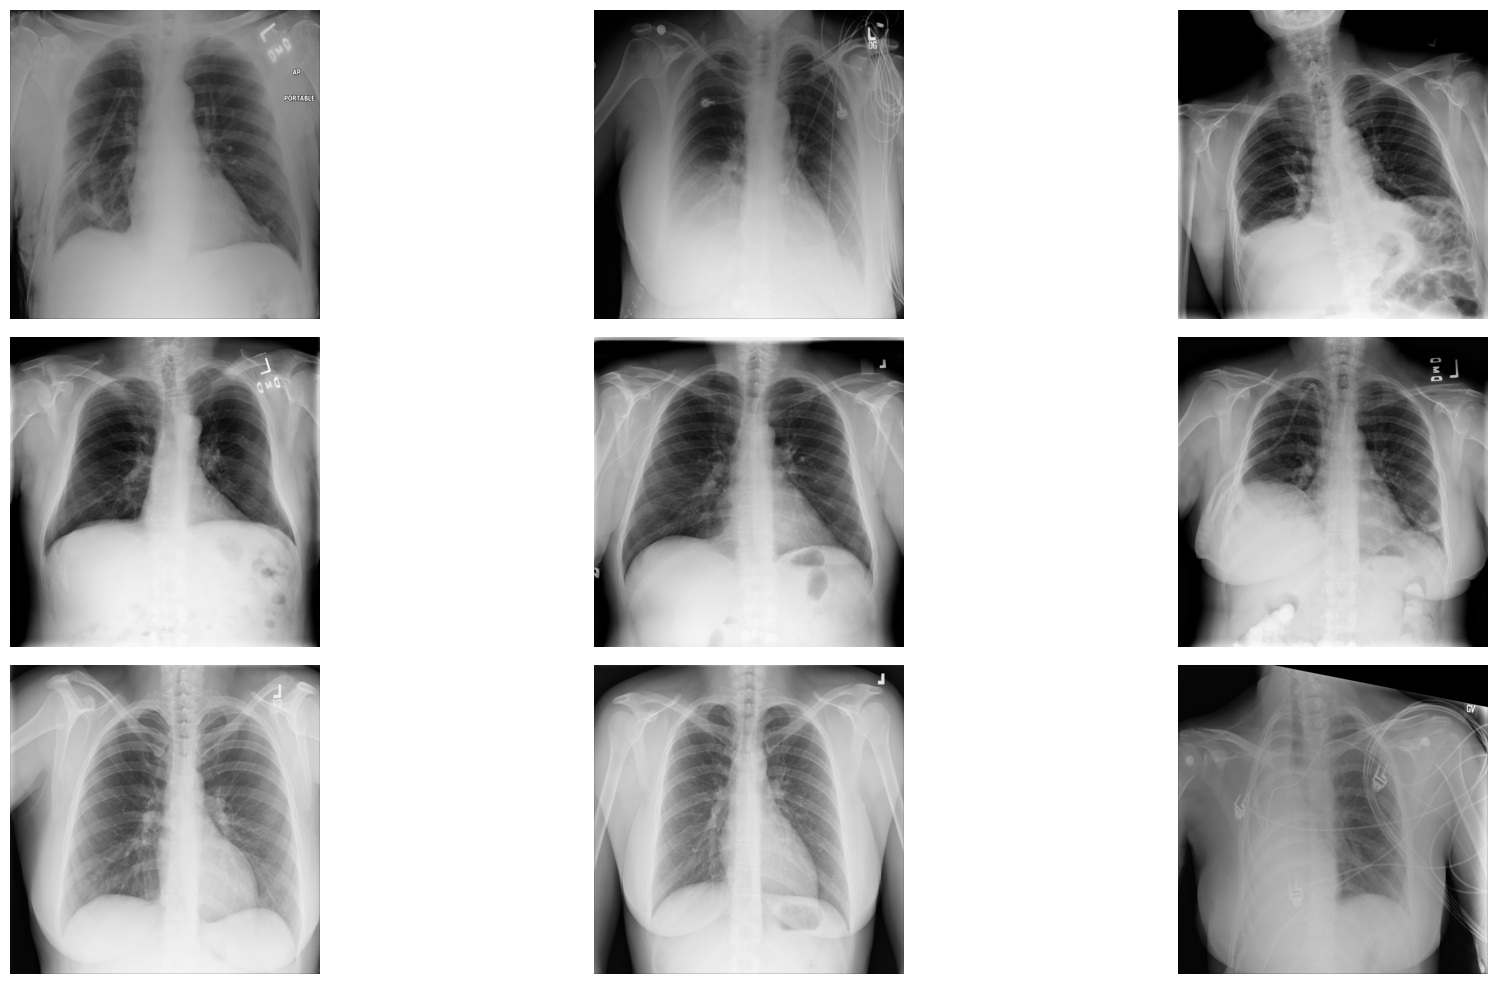

In [14]:
# Location of the image dir
img_dir = 'data/CXR8/images'

# Create a dictionary mapping image names to their full paths
image_paths = {}
for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file.endswith('.png'):
            image_paths[file] = os.path.join(root, file)

# Extract image file names from the dataframe's 'id' column
images = train_df['id'].values

# Randomly select 9 image file names from the dataframe
random_images = [np.random.choice(images) for i in range(9)]

# Display random images
plt.figure(figsize=(20, 10))

# Iterate and plot the random images by finding their corresponding paths
for i in range(9):
    plt.subplot(3, 3, i + 1)
    
    # Get the full path of the image using the dictionary
    img_path = image_paths.get(random_images[i])
    
    # Check if image path exists in the dictionary
    if img_path:
        img = plt.imread(img_path)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

# Adjust subplot parameters to give specified padding
plt.tight_layout()
plt.show()

### Investigate a single image
Looking at the first image in the dataset and printing out some details of the image contents.

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.5025 and the standard deviation is 0.2644


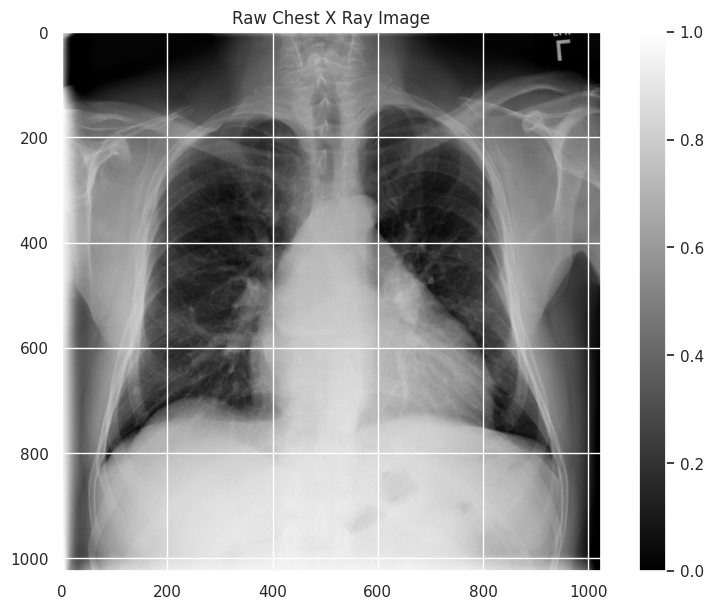

In [17]:
# Get the first image listed in the train_df dataframe
sample_img = train_df.id[0]

# Initialize a variable to store the full path of the first encountered image
raw_image_path = None

# Traverse through all subdirectories in img_dir to find the first match
for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file == sample_img:  
            raw_image_path = os.path.join(root, file)
            break
    if raw_image_path:  
        break

# Load and display the image if found
if raw_image_path:
    raw_image = plt.imread(raw_image_path)
    plt.imshow(raw_image, cmap='gray')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.colorbar()
    plt.title('Raw Chest X Ray Image')
else:
    print(f"Image {sample_img} not found.")

print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

### Investigate pixel value distribution
Plotting the distribution of pixel values in the image shown above. 

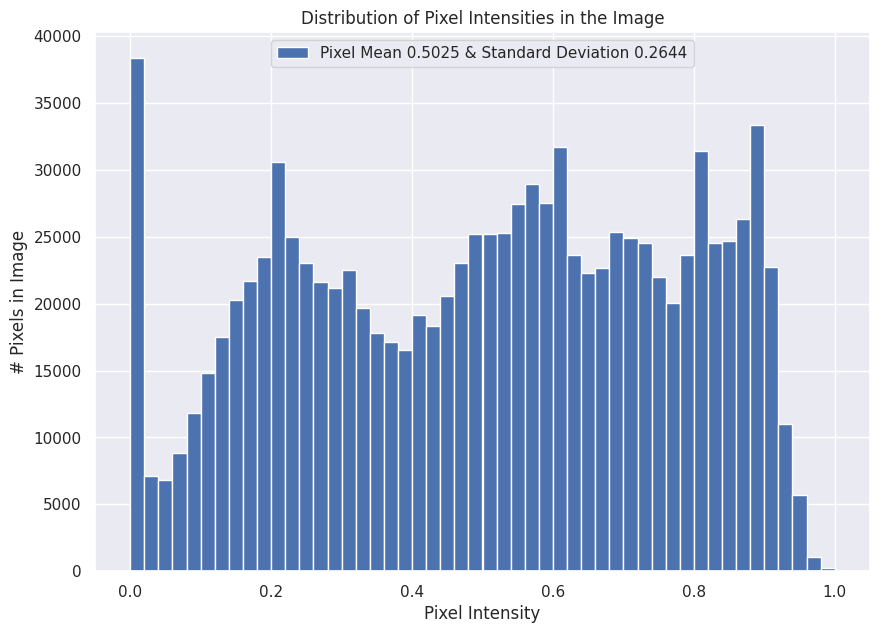

In [18]:
pixels = np.reshape(raw_image,raw_image.shape[0]*raw_image.shape[1])
plt.hist(pixels, bins=50, label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}')
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()